In [1]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import pickle
import time
import random
from collections import Counter

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif,chi2, mutual_info_classif, VarianceThreshold, RFE, SelectFromModel, SequentialFeatureSelector as SFS

from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier#, GradientBoostingClassifier, ExtraTreesClassifier


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import matplotlib.pyplot as plt
import python_files.functions_barcelona_Correlations as fb3

%load_ext autoreload
%autoreload 2

In [2]:
accidents=pd.read_csv('./data/accidents_weather_eng_2023.csv')


cat_columns=[]
num_columns=[]
to_drop=['index','num_incident', 'num_severly_injured','num_deaths',\
         'num_minorly_injured','num_victims','street_code', 'dates','datetimes','utm_x','utm_y','district_code']
for col in accidents:
    if 'Unnamed' in col:
        accidents=accidents.drop(col,axis=1)
for col in accidents.columns:
    if col in to_drop:
        accidents=accidents.drop(col,axis=1)
    elif 'bins' in col:
        cat_columns.append(col)
    elif ('_color' in col) or ('_model' in col) or ('_brand_name' in col): 
        pass # Do no carry much information
    elif ('vehicle_' in col) or ('people_role_' in col):
        num_columns.append(col)
    elif 'seniority' in col:
        num_columns.append(col)
    elif 'license' in col:
        pass #license is discarded due to the fact that the information it provides is already 
        # contained in vehicles
    elif col =='target':
        pass
    elif 'num' in col or '_count' in col:
        num_columns.append(col)
    elif accidents[col].nunique()<76:
        cat_columns.append(col)
    elif accidents[col].dtypes==float:
        num_columns.append(col)
len(cat_columns),len(num_columns),len(accidents.columns),len(accidents.columns)-len(cat_columns)-len(num_columns)

(15, 31, 53, 7)

In [3]:
cat_columns

['district',
 'neighborhood',
 'weekday',
 'year',
 'month',
 'day',
 'hour',
 'ped_cause',
 'cause',
 'age_bins',
 'accident_type',
 'street_name_bins',
 'neighborhood_bins',
 'is_holiday',
 'crossing_street']

In [4]:
pending=[x for x in accidents.columns if x not in cat_columns+num_columns]
for col in pending:
    print(col,accidents[col].dtypes, accidents[col].nunique())

street_name object 9312
vehicle_model object 70981
vehicle_brand_name object 16576
vehicle_color object 3838
license object 1506
datetime object 67652
target int64 2


<a id='start'></a>

# Selecting Features:
1. [**Numerical Features**.](#num_fea)
    - [FILTER: Variance Threashold.](#num_vt) Univariate features are eliminated
    - [FILTER: ANOVA](#anova)
    - [FILTER: Pearson, Kendall, Spearman Correlation.](#num_corr)
    - [FILTER: Information Gain.](#inf_gain)
    - [WRAPPER: Recursive Feature Elimination.](#num_rfe)
    - [EMBEDDED: RandomForestClassifier](#num_rf)
    - [EMBEDDED: Lasso.](#num_lasso)
3. [**Categorical Features**.](#cat_fea)
    - [FILTER: Variance Threashold.](#cat_vt)
    - [FILTER: Chi Square and Mutual Information](#chi_sq)
    - [FILTER: Cramer's V, Theil's U Correlation.](#cat_corr)
    - [FILTER: Mutual Information/Information Gain.](#mut_info)
    - [WRAPPER: Recursive Feature Elimination.](#cat_rfe)
    - [EMBEDDED: RandomForestClassifier](#cat_rf)
    - [EMBEDDED: Lasso.](#cat_lasso)
4. [**Sequential feature selection.**](#wrapper_global)  I will skip the exhaustive and backward just for the sake of time.
    - [Forward Feature Selection.](#forward)

<a id='num_fea'></a>
1. **Numerical Features**.

[back top](#start)

In [5]:
correlations= abs(accidents[num_columns].corr())
correlations=correlations.replace(1,0)
for col in num_columns:
    #print(correlations[col])
    if correlations[col].max()>0.8:
        print(col, round(correlations[col].max(),2),correlations[col].sort_values(ascending=False).index[0])
        num_columns.remove(correlations[col].sort_values(ascending=False).index[0])
num_columns

temp_avg 1.0 temp_min
temp_max 1.0 temp_avg
windspeed 0.87 max_windspeed


['num_vehicles',
 'vehicle_bicycle',
 'vehicle_bus',
 'vehicle_car',
 'vehicle_misc_vehicle',
 'vehicle_moped',
 'vehicle_motorcycle',
 'vehicle_personal motor vehicles',
 'vehicle_taxi',
 'vehicle_truck',
 'vehicle_van',
 'people_role_driver',
 'people_role_passenger',
 'people_role_pedestrian',
 'age_driver',
 'driver_u_25_count',
 'gender_driver_male_count',
 'gender_driver_female_count',
 'license_seniority',
 'temp_max',
 'relative_humidity',
 'precipitation',
 'windspeed',
 'wind_direction',
 'pressure',
 'solar_radiation',
 'street_name_count',
 'neighborhood_count']

In [6]:
#To avoid further problems when using ordinal encoder. I decided to go to a classic train_test split
X_train_num, X_test_num, y_train, y_test=train_test_split(accidents[num_columns],accidents.target,test_size=0.1) 

<a id='num_vt'></a>
1. **Numerical Features**.
    - FILTER: Variance Threashold.
   
[back top](#start)

In [7]:
vt=VarianceThreshold()
vt.fit(X_train_num)
[num_columns[col[0]] for col in enumerate(vt.get_support()) if  not col[1]]
 ##=======>>No changes

[]

<a id='anova'></a>
1. **Numerical Features**.
    - FILTER: ANOVA.
   
[back top](#start)

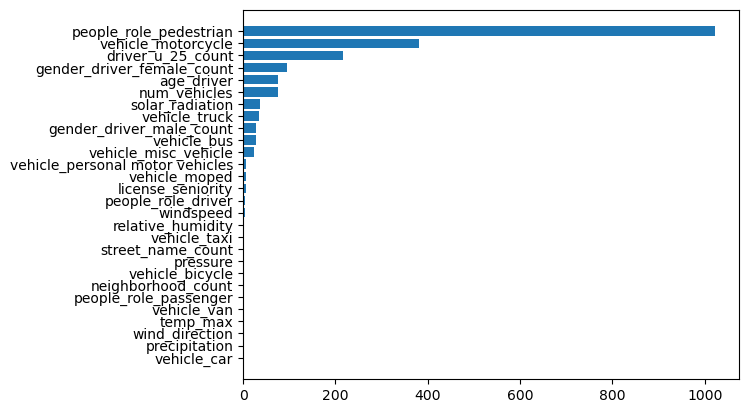

In [8]:
numerical_chosen=[]
def select_features(X_train, y_train, X_test,score_func=f_classif):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_num, y_train, X_test_num)
# what are scores for the features
sorted_columns=sorted([x for x in zip(num_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
anova_sel=[col[0] for col in sorted_columns[:3]]
numerical_chosen.extend(anova_sel)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.barh(cols[::-1], scores[::-1])
plt.show()

<a id='num_corr'></a>
1. **Numerical Features**.
    - FILTER: Pearson, Kendall and Spearman Correlations.
   
[back top](#start)

In [9]:
pearson_sel=list(abs(accidents[num_columns +['target']].corr()['target']).sort_values(ascending=False)[1:4].index)
print('Pearson Selection: ','\n',pearson_sel)
numerical_chosen.extend(pearson_sel)
kendall_sel=list(abs(accidents[num_columns +['target']].corr(method='kendall')['target']).sort_values(ascending=False)[1:4].index)
numerical_chosen.extend(kendall_sel)
print('Kendall Selection: ','\n',kendall_sel)
spearman_sel=list(abs(accidents[num_columns +['target']].corr(method='spearman')['target']).sort_values(ascending=False)[1:4].index)
numerical_chosen.extend(spearman_sel)
print('Spearman Selection: ','\n',spearman_sel)

Pearson Selection:  
 ['people_role_pedestrian', 'vehicle_motorcycle', 'driver_u_25_count']
Kendall Selection:  
 ['people_role_pedestrian', 'vehicle_motorcycle', 'num_vehicles']
Spearman Selection:  
 ['people_role_pedestrian', 'vehicle_motorcycle', 'num_vehicles']


<a id='inf_gain'></a>
1. **Numerical Features**.
    - FILTER: Information Gain.
   
[back top](#start)

In [10]:
importances=mutual_info_classif(X_train_num, y_train)
info_gain_sel=list(pd.DataFrame(importances,columns=['InformationGain'],index=num_columns).sort_values('InformationGain',ascending=False).index[:3])
numerical_chosen.extend(info_gain_sel)
info_gain_sel

['num_vehicles', 'people_role_driver', 'gender_driver_male_count']

<a id='num_rfe'></a>
1. **Numerical Features**.
    - WRAPPER: Recursive Feature Elimination.
   
[back top](#start)

In [11]:
lr=LogisticRegression(max_iter=300)
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train_num)
X_test_minmax=min_max_scaler.transform(X_test_num)
# for n_cols in range(1,X_train_num.shape[1]):

#     rfe=RFE(lr,n_features_to_select=n_cols)
#     rfe.fit(X_train_minmax,y_train)
#     #print([num_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1])
rfe=RFE(lr,n_features_to_select=3)
rfe.fit(X_train_minmax,y_train)
rfe_sel=[num_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1]
numerical_chosen.extend(rfe_sel)
print('Three Selected by RFE: ','\n', rfe_sel)

Three Selected by RFE:  
 ['vehicle_bus', 'vehicle_motorcycle', 'people_role_pedestrian']


<a id='num_rf'></a>
1. **Numerical Features**.
    - EMBEDDED: Random Forest Classifier.
   
[back top](#start)

In [12]:
rf=RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_train_num,y_train)
rf_sel=sorted([x[0] for x in zip(num_columns,rf.feature_importances_)],key=lambda x:x[1],reverse=True)[:3]
numerical_chosen.extend(rf_sel)
print('Three Selected by RandomForest: ','\n', rf_sel)

Three Selected by RandomForest:  
 ['num_vehicles', 'street_name_count', 'driver_u_25_count']


<a id='num_lasso'></a>
1. **Numerical Features**.
    - EMBEDDED: Lasso.
   
[back top](#start)

In [13]:
# Lasso
for c in np.linspace(0.001,0.0001,4):
    #print(c)
    lr=LogisticRegression(C=c,penalty='l1',solver='liblinear').fit(X_train_num,y_train)
    selector = SelectFromModel(estimator=lr,prefit=True)
    num_features=len([x[0] for x in zip(num_columns,selector.get_support()) if x[1]])
    #print(num_features)
    # if num_features == 6:
    #     print(num_features,'\n',[x[0] for x in zip(num_columns,selector.get_support()) if x[1]])
    if num_features <=3:
        print('YEAH')
        print(num_features,'\n',[x[0] for x in zip(num_columns,selector.get_support()) if x[1]])
        lasso_sel=[x[0] for x in zip(num_columns,selector.get_support()) if x[1]]
        break
numerical_chosen.extend(lasso_sel)
print('Three Selected by Lasso: ','\n', lasso_sel)

YEAH
3 
 ['pressure', 'solar_radiation', 'street_name_count']
Three Selected by Lasso:  
 ['pressure', 'solar_radiation', 'street_name_count']


In [14]:
##Numerical selected
#numerical_chosen=Counter(numerical_chosen)
# model_dict={}
# model_dict['numerical_features']=numerical_chosen
# # with open('./data/model_charac.pkl', 'wb') as f:
# #     pickle.dump(model_dict, f, pickle.HIGHEST_PROTOCOL)
# model_dict

<a id='cat_fea'></a>
2. **Categorical Features**.

[back top](#start)

In [15]:
X_cat=accidents[cat_columns].copy()
y=accidents.target
X_train_cat, X_test_cat, y_train, y_test=train_test_split(accidents[cat_columns],accidents.target,test_size=0.1) 

<a id='cat_vt'></a>
1. **Categorical Features**.
    - FILTER: Variance Threashold.
   
[back top](#start)

In [16]:
def prepare_inputs_cat(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc
X_cat_enc=prepare_inputs_cat(X_cat)

In [17]:
vt=VarianceThreshold()
vt.fit(X_cat_enc)
[num_columns[col[0]] for col in enumerate(vt.get_support()) if  not col[1]]
 ##=======>>No changes

[]

<a id='chi_sq'></a>

2. **Categorical Features**.
    - FILTER: Chi Square.
   
[back top](#start)

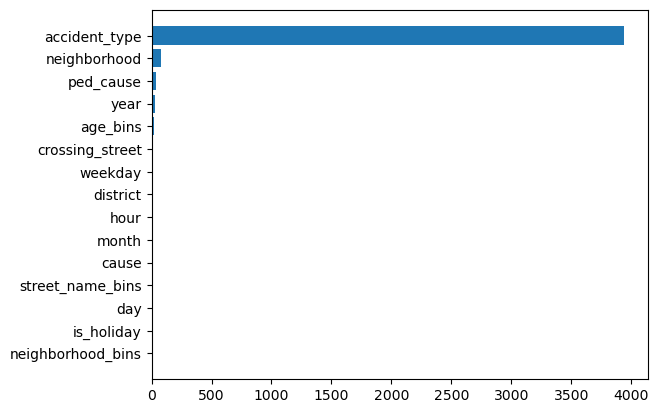

In [18]:
categorical_chosen=[]
def select_features_cat(X, y,score_func=f_classif):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X, y)
    # transform train input data
    X_fs = fs.transform(X)
    return X_fs, fs
 
# feature selection
X_fs, fs = select_features_cat(X_cat_enc, y,chi2)
# what are scores for the features
sorted_columns=sorted([x for x in zip(cat_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
chi2_sel=[col[0] for col in sorted_columns[:3]]
categorical_chosen.extend(chi2_sel)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.barh(cols[::-1], scores[::-1])
plt.show()

<a id='cat_corr'></a>

2. **Categorical Features**.
    - FILTER: Cramers V, Theils U Correlations.
   
[back top](#start)

In [19]:
cramers, theils = [],[]
for col in cat_columns:
    correlation_c=fb3.cramers_corrected_stat(accidents[col],accidents.target)
    correlation_u=fb3.theils_u(accidents[col],accidents.target)
    #print(col, 'cramers', correlation_c)
    cramers.append((col,correlation_c))
    #print(col,'theils', correlation_u)
    theils.append((col,correlation_u))
cram_sel=[col[0] for col in sorted(cramers,key=lambda x:x[1],reverse=True)[0:3]]
categorical_chosen.extend(cram_sel)
print('Selected by Cramers V: ', '\n',cram_sel)
thei_sel=[col[0] for col in sorted(theils,key=lambda x:x[1],reverse=True)[:3]]
categorical_chosen.extend(thei_sel)
print('Selected by Theils U: ', '\n',thei_sel)

Selected by Cramers V:  
 ['accident_type', 'ped_cause', 'cause']
Selected by Theils U:  
 ['cause', 'accident_type', 'ped_cause']


<a id='mut_info'></a>

2. **Categorical Features**.
    - FILTER: Mutual Information/Information Gain.
   
[back top](#start)

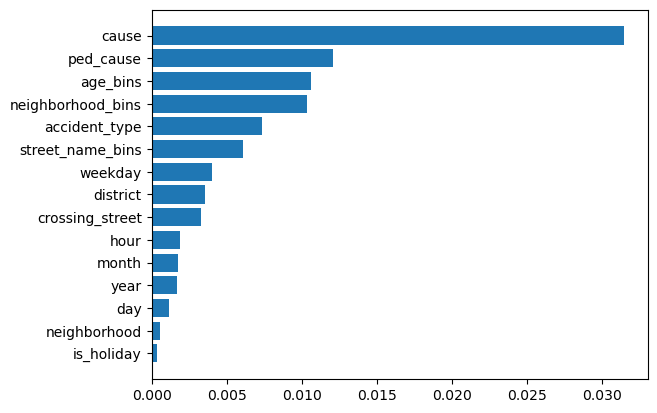

In [20]:
# feature selection
X_fs, fs = select_features_cat(X_cat_enc, y,mutual_info_classif)
# what are scores for the features
sorted_columns=sorted([x for x in zip(cat_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
mut_sel=[col[0] for col in sorted_columns[:3]]
categorical_chosen.extend(mut_sel)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.barh(cols[::-1], scores[::-1])
plt.show()

<a id='cat_rfe'></a>

2. **Categorical Features**.
    - WRAPPER: Recursive Feature Elimination.
   
[back top](#start)

In [21]:
lr=LogisticRegression(max_iter=500, C=0.001)
# min_max_scaler = MinMaxScaler()
# X_cat_minmax = min_max_scaler.fit_transform(X_cat_enc)
#X_test_minmax=min_max_scaler.transform(X_test_num)
# for n_cols in range(1,X_cat_enc.shape[1]):

#     rfe=RFE(lr,n_features_to_select=n_cols)
#     rfe.fit(X_cat_enc,y)
#     #print([num_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1])\
#     if n_cols%10==0:
#         print(n_cols)
rfe=RFE(lr,n_features_to_select=3)
rfe.fit(X_cat_enc,y)
rfe_sel=[cat_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1]
categorical_chosen.extend(rfe_sel)
print('Three Selected by RFE: ','\n', rfe_sel)

Three Selected by RFE:  
 ['cause', 'age_bins', 'accident_type']


<a id='cat_rf'></a>

2. **Categorical Features**.
    - EMBEDDED: Random Forest Classifier.
   
[back top](#start)

In [22]:
rf=RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_cat_enc,y)
rf_sel=sorted([x[0] for x in zip(cat_columns,rf.feature_importances_)],key=lambda x:x[1],reverse=True)[:3]
categorical_chosen.extend(rf_sel)
print('Three Selected by RandomForest: ','\n', rf_sel)

Three Selected by RandomForest:  
 ['street_name_bins', 'is_holiday', 'crossing_street']


<a id='cat_lasso'></a>

2. **Categorical Features**.
    - EMBEDDED: Lasso.
   
[back top](#start)

In [23]:
# Lasso
for c in np.linspace(0.001,0.00001,4):
    #print(c)
    lr=LogisticRegression(C=c,penalty='l1',solver='liblinear').fit(X_cat_enc,y)
    selector = SelectFromModel(estimator=lr,prefit=True)
    num_features=len([x[0] for x in zip(cat_columns,selector.get_support()) if x[1]])
    print(num_features)
    # if num_features == 6:
    #     print(num_features,'\n',[x[0] for x in zip(cat_columns,selector.get_support()) if x[1]])
    if num_features <=3:
        print('YEAH')
        print(num_features,'\n',[x[0] for x in zip(cat_columns,selector.get_support()) if x[1]])
        lasso_sel=[x[0] for x in zip(cat_columns,selector.get_support()) if x[1]]
        break
categorical_chosen.extend(lasso_sel)
print('Three Selected by Lasso: ','\n', lasso_sel)

10
10
8
3
YEAH
3 
 ['neighborhood', 'day', 'hour']
Three Selected by Lasso:  
 ['neighborhood', 'day', 'hour']


In [24]:
##Categorical selected
#categorical_chosen=Counter(categorical_chosen)
#model_dict['categorical_features']=categorical_chosen

<a id='wrapper_global'></a>
4. **Sequential feature selection**.
   
[back top](#start)

In [25]:
X=accidents[cat_columns+num_columns]
y=accidents.target

# I am going to redribute the features and I will treat all categoriocal features  that are int or float as a numerical

ambidext_columns= accidents[cat_columns].select_dtypes(include='number').columns.to_list()
numeric_features = num_columns+ ambidext_columns
numeric_features
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = [col for col in cat_columns if col not in ambidext_columns]
#categorical_features.remove('neighborhood')

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


<a id='forward'></a>
    - Sequential Feature Selection:
    
        Forward.
   
[back top](#start)

In [26]:
forward=SFS(LogisticRegression(max_iter=500),
       n_features_to_select=10,
       scoring='recall')

st=time.time()
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", forward)]
)

#X_train, X_test, y_train,et-st y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X, y)
et=time.time()
forward_features=clf.get_feature_names_out()

print("Selected features: ", forward_features)
et-st

Selected features:  ['num__vehicle_bus' 'num__vehicle_motorcycle'
 'num__people_role_pedestrian' 'num__gender_driver_male_count'
 'num__windspeed' 'num__street_name_count'
 'cat__ped_cause_Crossing outside ped crossing' 'cat__ped_cause_unknown'
 'cat__cause_Speeding' 'cat__accident_type_frontal']


545.9825191497803

In [36]:
list(set([col[5:] for col in forward_features if col.startswith('num')]))

['vehicle_motorcycle',
 'people_role_pedestrian',
 'street_name_count',
 'vehicle_bus',
 'gender_driver_male_count',
 'windspeed']

In [37]:
##Do not run again
numerical_chosen.extend(list(set([col[5:] for col in forward_features if col.startswith('num')])))
categorical_chosen.extend(list(set([col[5:].rpartition('_')[0] for col in forward_features if col.startswith('cat')])))

In [38]:
model_dict={}
model_dict['numerical_features']=Counter(numerical_chosen)
model_dict['categorical_features']=Counter(categorical_chosen)
##Categorical selected
with open('./data/model_charac.pkl', 'wb') as f:
    pickle.dump(model_dict, f, pickle.HIGHEST_PROTOCOL)